# DSPIN Tutorial (Gene DSPIN) v0

In [1]:
import numpy as np
from tqdm import tqdm
import anndata as ad
import sys
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.io import savemat, loadmat
import os
import pandas as pd

**Please make sure the current path is parallel with the folder "util"** 

Use other ways to import DSPIN class otherwise.

In [2]:
sys.path.append("..")
from util.dspin_abstract import DSPIN
import util.plot as plot

/Users/ygong/Documents/caltech/dspin/dspin_final/DSPIN-abstract/test/../util/compute.py:374: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


## Data Exploration

### Load Data
Preprocessing Should be Done Before Using DSPIN

In [3]:
data_folder = '../data/HSC_simulation'
save_path = '../test/test/HSC_simulation'

In [4]:
cadata = ad.read_h5ad(data_folder + '/hsc_simulation_with_perturbations.h5ad')

In [5]:
cadata

AnnData object with n_obs × n_vars = 13000 × 11
    obs: 'cell', 'sample_id'
    var: 'gene'

Notice that it is a small dataset with 10 genes, so we will use Gene-DSPIN later.

In [6]:
cadata.var

,gene
0,Cebpa
1,EgrNab
2,Eklf
3,Fli1
4,Fog1
5,Gata1
6,Gata2
7,Gfi1
8,Pu1
9,Scl


In [7]:
gene_list = cadata.var['gene'].values
num_gene = len(gene_list)
samp_list = np.unique(cadata.obs['sample_id'])
aux_ind = [- 1, 0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 3, 4, 5, 6, 7, 8, 9]
samp_name = ['CONTROL'] + [gene + '\nknock-down' for gene in gene_list] + [gene + '\nactivation' for gene in gene_list]
samp_list_name = [samp_name[aux_ind[ii] + 1] for ii in range(num_gene * 2 + 1)]

## Initialize a DSPIN Object

When a DSPIN instance is initialized, based on the comparison between the number of spin and the 
number of genes of the anndata, it automatically initiates a GeneDSPIN or a ProgramDSPIN. In the following example, a GeneDSPIN is iniatialized. The major difference between GeneDSPIN and ProgramDSPIN is that the later requires ONMF to cluster gene programs.

In [8]:
num_spin = cadata.shape[1] # num of gene
model = DSPIN(cadata, save_path, num_spin=num_spin)

11 genes have expression in more than 0.02 of the cells
Saving path does not exist. Creating a new folder.
GeneDSPIN initialized.


## Network Inference
Please set sample_col_name be the column name for sample id

An example list (optional) is a subset of all sample ids.

In [9]:
model.network_infer(sample_col_name='sample_id')

Using maximum_likelihood for network inference.
Progress: 5, Network gradient: 50.678354
Progress: 10, Network gradient: 22.020509
Progress: 15, Network gradient: 8.546760
Progress: 20, Network gradient: 8.293373
Progress: 25, Network gradient: 3.795650
Progress: 30, Network gradient: 2.124027
Progress: 35, Network gradient: 1.747828
Progress: 40, Network gradient: 0.981062
Progress: 45, Network gradient: 0.644291
Progress: 50, Network gradient: 0.553483
Progress: 55, Network gradient: 0.319290
Progress: 60, Network gradient: 0.166491
Progress: 65, Network gradient: 0.143870
Progress: 70, Network gradient: 0.100941
Progress: 75, Network gradient: 0.072293
Progress: 80, Network gradient: 0.050324
Progress: 85, Network gradient: 0.036800
Progress: 90, Network gradient: 0.027779
Progress: 95, Network gradient: 0.021083
Progress: 100, Network gradient: 0.015412


## Network Plotting

The names for gene programs can be set by the user.
Otherwise, users can call function "temporary_spin_name" in plot.py to create names for gene programs
from the first five genes in each program.

In [10]:
gene_list = cadata.var['gene']

In [11]:
cur_j = model.network 

In [12]:
sys.path.append("..")
from importlib import reload
import util.plot
reload(util.plot)
from util.plot import plot_final

In [13]:
# predefined spin order
spin_order = np.array([2, 4, 5, 9, 1, 8, 10, 0, 7, 3, 6])

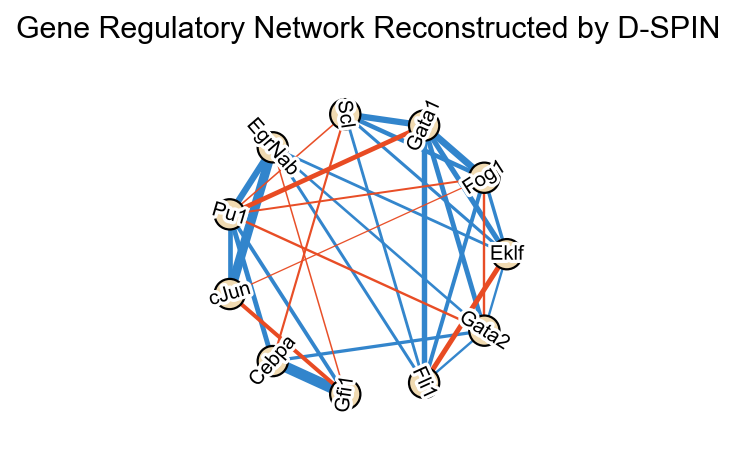

In [14]:
plot.plot_final(gene_program_name=gene_list, 
                cur_j=cur_j,
                cluster=False,
                spin_order=spin_order,
                linewz=2,
                figsize=[5, 3])

## Compare the inferred network with the ground truth

In [15]:
import re

ref_network = pd.read_csv(data_folder + '/refNetwork.csv')

gene_list = cadata.var['gene']
j_mat = np.zeros([len(gene_list), len(gene_list)])

for row in ref_network.itertuples():
    gene1 = row.Gene1
    gene2 = row.Gene2
    interaction = row.Type
    if interaction == '+':
        j_mat[gene_list == gene1, gene_list == gene2] = 1
    elif interaction == '-':
        j_mat[gene_list == gene1, gene_list == gene2] = -1

j_mat[(j_mat == - 1) & (j_mat.T == 1)] = 1
j_mat += j_mat.T
j_mat = np.sign(j_mat)

j_ref = j_mat.copy()


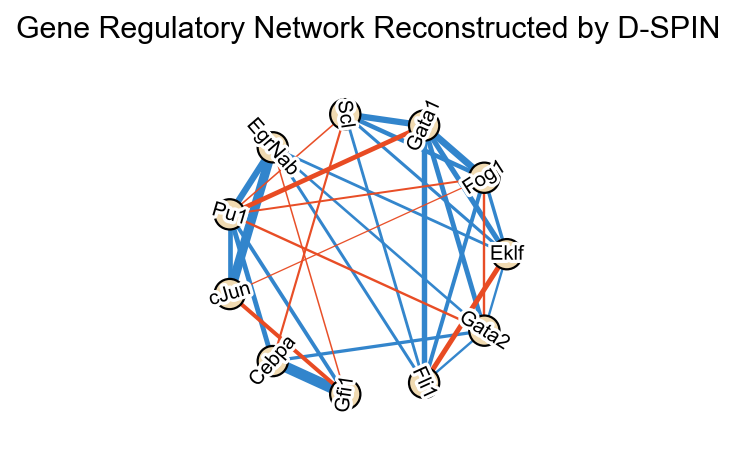

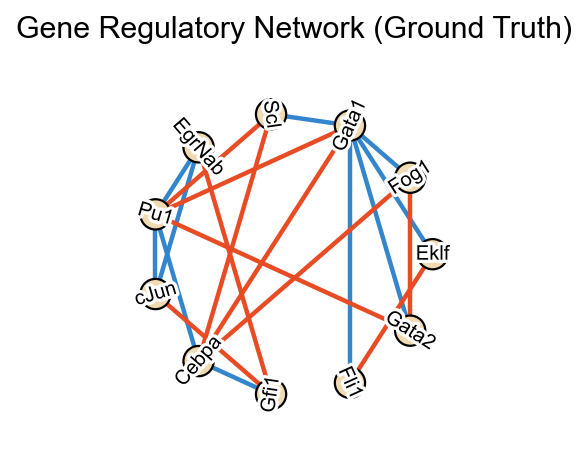

In [16]:
plot.plot_final(gene_program_name=gene_list, 
                cur_j=cur_j,
                cluster=False,
                spin_order=spin_order,
                linewz=2,
                figsize=[5, 3])

plot.plot_final(gene_program_name=gene_list, 
                cur_j=j_ref,
                cluster=False,
                spin_order=spin_order,
                linewz=2,
                figsize=[5, 3],
                title="Gene Regulatory Network (Ground Truth)")

## Compute accuracy of the inferred network

In [17]:
def precision_recall_curve(j_ref, cur_j):
    num_spin = j_ref.shape[0]
    max_k = int(num_spin * (num_spin - 1) / 2)

    j_ref = np.triu(j_ref, k=1)
    cur_j = np.maximum(np.abs(cur_j), np.abs(cur_j).T)
    cur_j = np.triu(cur_j, k=1)

    # Flatten and sort the upper triangular portions of the matrices
    ref_indices = np.argsort(np.abs(j_ref), axis=None)[::-1]
    cur_indices = np.argsort(np.abs(cur_j), axis=None)[::-1]

    ref_values = np.sort(np.abs(j_ref), axis=None)[::-1]
    cur_values = np.sort(np.abs(cur_j), axis=None)[::-1]

    ref_indices = ref_indices[ref_values > 0]
    cur_indices = cur_indices[cur_values > 0]

    # Compute whether each inferred edge is in the list by order
    edge_in_list = np.isin(cur_indices, ref_indices)
    correct_predictions_cumsum = np.cumsum(edge_in_list)

    precision_values = correct_predictions_cumsum / np.arange(1, max_k+1)
    recall_values = correct_predictions_cumsum / len(ref_indices)

    return precision_values, recall_values

In [18]:
precision, recall = precision_recall_curve(j_ref, cur_j)
print('Top 10 accuracy %.2f , Top 15 accuracy %.2f, Top 20 accuracy %.2f' % (precision[9], precision[14], precision[19]))

Top 10 accuracy 1.00 , Top 15 accuracy 0.87, Top 20 accuracy 0.65
